# Supernova spectrum matching and classification notebook

### Import packages needed and define a stats function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions import ProcessSpectra, BinSpec, split, get_classification, dered, get_spec_matches, target_wavelength_range
from glob import glob
from joblib import dump, load

In [45]:
def get_z_stats(get_sn = False, get_type = False, plot = True ):
    '''
    Returns the stats for either a particular supernova as defined by get_sn,
    or a particular type as defined by get_type.
    Output is one tuple and two arrays; 
    
    [0] = (median, mean, std)
    [1] = redshift array
    [2] = weights array for plt.hist weights argument
    '''
    
    
    # set the empty lists
    stats = []
    w = []
    
    # set parameters for a supernova or a type
    if get_sn:
        sn_matches = [get_sn]
        list_to_use = sne
        
    if get_type:
        sn_matches = set(sne)
        list_to_use = types
     
    # iterate through the lists to get the redshifts that match the conditions
    for this_sn in sn_matches:        
        for idx ,obj in enumerate(list_to_use):
            
            if (obj == this_sn) or (obj == get_type):
                stats.append(zs[idx])
                w. append(sorted_scores[idx])
                
    # normalise the scores to the score in the list. This is for 'weights' in plt.hist            
    w =  ( w / max(sorted_scores) ) ** 4 
    
    # cast as numpy array
    stats = np.array(stats)
    w = np.array(w)
    
    if plot:
        plt.hist(stats, weights = w, color = 'k', facecolor = 'tab:green', zorder = 0, rwidth= 0.9, density = True)
        plt.axvline(x = np.average(stats, weights = w), linestyle = 'dashed' , color = 'k')
        plt.axvline(x = np.average(stats, weights = w) + np.std(stats), linestyle = 'dotted', color = 'k' )
        plt.axvline(x = np.average(stats, weights = w) - np.std(stats), linestyle = 'dotted', color = 'k' )
        plt.xlabel('Redshift')
        plt.ylabel('weighted counts')
    
    return (np.median(stats), np.average(stats, weights = w), np.std(stats) ), stats, w


Load the model and the list of classifications for the spectra in the model

In [46]:
# Load the model
model_location = './models/Gr13_KNNClassification_model.k=1000.joblib'
clf = load(model_location) 

# load the class list for this model
classlist = np.loadtxt('./PCA_ready/classlist.Gr13.txt',dtype='str')
classlist.sort()

# set the list of the spectra for the templates
ref_sne = glob('./spectra/*')
ref_location = './spectra/'

## User defined
### Set the input spectrum

In [47]:
specname = '2019cri_Ic-0.041.asci'

spectrum = f'./for_classification/{specname}'


# Get the best match and the scores for all the matches

In [48]:
best_match, indices, scores = get_classification(spectrum, clf)
best_match_properties = split(best_match)[0]
best_match_properties
print(f'The best match is {best_match_properties[0]} {best_match_properties[1]} (t = {best_match_properties[3]} d) at z = {best_match_properties[2]}')

The best match is Ic-7 SN2011bm (t = 10.89 d) at z = 0.04


### Sort all the matches by score then return them in a list

In [49]:
sorted_scores, sorted_idxs = zip(*list(sorted(zip(scores,indices), reverse=True)))

# Set if redshift is known
redshift = False

a  = get_spec_matches(idxs = sorted_idxs, z = redshift, classlist = classlist )
types, sne, zs, epochs, all_specs = zip(*a)

# list the top 15 matches
a[:15]

[('Ic-7', 'SN2011bm', 0.04, 10.89, 'Ic-7_SN2011bm_10.89_.txt'),
 ('Ic-7', 'SN2011bm', 0.042, 10.89, 'Ic-7_SN2011bm_10.89_.txt'),
 ('Ic-7', 'SN2011bm', 0.038, 10.89, 'Ic-7_SN2011bm_10.89_.txt'),
 ('Ic-7', 'SN2011bm', 0.044, 10.89, 'Ic-7_SN2011bm_10.89_.txt'),
 ('Ib', 'SN2009jf', 0.048, 1.18, 'Ib_SN2009jf_1.18_.txt'),
 ('Ib', 'SN2009jf', 0.046, 1.18, 'Ib_SN2009jf_1.18_.txt'),
 ('Ib', 'SN2009jf', 0.044, 1.18, 'Ib_SN2009jf_1.18_.txt'),
 ('Ic-7', 'SN2011bm', 0.036, 10.89, 'Ic-7_SN2011bm_10.89_.txt'),
 ('Iax', 'SN2010ae', 0.032, 3.69, 'Iax_SN2010ae_3.69_.txt'),
 ('Iax', 'SN2010ae', 0.03, 3.69, 'Iax_SN2010ae_3.69_.txt'),
 ('Ic-7', 'SN2007gr', 0.056, -9.51, 'Ic-7_SN2007gr_-9.51_.txt'),
 ('Ic-7', 'SN2007gr', 0.058, -9.51, 'Ic-7_SN2007gr_-9.51_.txt'),
 ('Iax', 'SN2010ae', 0.034, 3.69, 'Iax_SN2010ae_3.69_.txt'),
 ('Ic-7', 'SN2011bm', 0.046, 10.89, 'Ic-7_SN2011bm_10.89_.txt'),
 ('Ic-7', 'SN2007gr', 0.054, -9.51, 'Ic-7_SN2007gr_-9.51_.txt')]

### Plot all the redshifts and phases

Text(0.5, 0, 'Redshift')

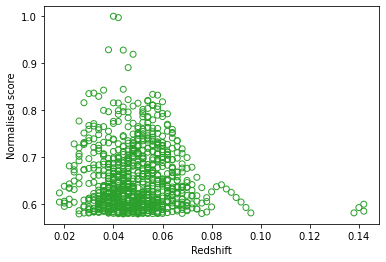

In [63]:
plt.scatter( zs, sorted_scores / max(sorted_scores), facecolor = 'none', color = 'tab:green')
plt.ylabel('Normalised score')
plt.xlabel('Redshift')

Text(0.5, 0, 'Epoch [days]')

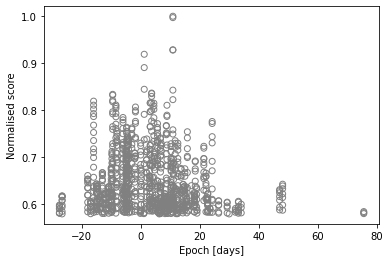

In [71]:
plt.scatter(epochs, sorted_scores / max(sorted_scores), facecolor = 'none', color = 'grey')
plt.ylabel('Normalised score')
plt.xlabel('Epoch [days]')

## Plot the best 15 matches

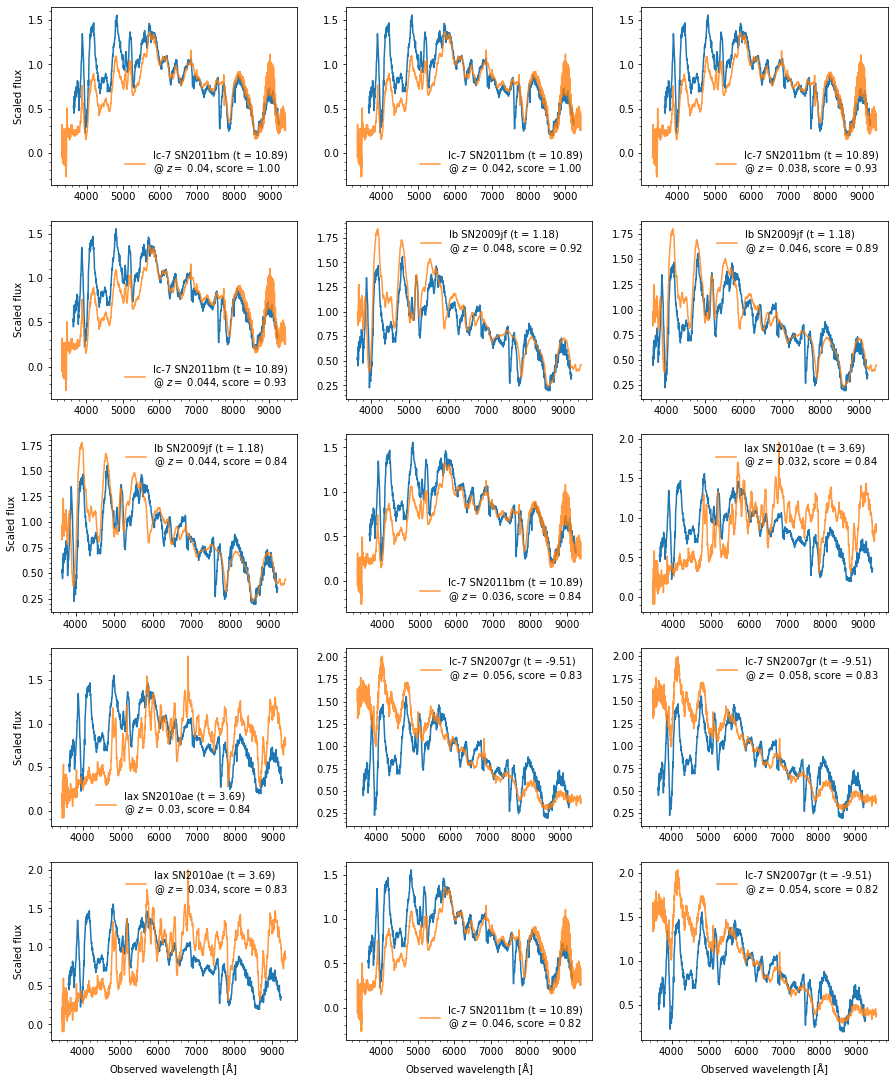

In [74]:
x , y = np.loadtxt(spectrum, usecols = (0,1) ,unpack= True )

ref_lam = 6000

scale = y[np.argmin(abs(x - ref_lam))]
y = y / scale

plt.figure(figsize = (15,19))
for i, spec in enumerate(all_specs):
    if i <15: 
        
        plt.subplot(5,3, i + 1)
        plt.plot(x, y)
    
        x_, y_ = np.loadtxt(ref_location + spec, unpack = True)
    
        x_ = x_ * (1 + zs[i])
    
        scale = y_[np.argmin(abs(x_ - ref_lam))]
        y_ = y_ / scale
        
        fit_score = sorted_scores[i] / max(sorted_scores)
        plt.plot(x_, y_, label = f'{types[i]} {sne[i]} (t = {epochs[i]})\n@ $z=$ {zs[i]}, score = {fit_score:.2f}', alpha = 0.8)

        plt.legend(frameon = False)
        plt.minorticks_on()
        # this messes up if i changes
        if i in  [0, 3, 6, 9, 12]:
            plt.ylabel('Scaled flux')
        if i in [14, 13 ,12]:
            plt.xlabel('Observed wavelength [$\mathrm{\AA}$]')
        
        
    else:
        break
    

## Plot the redshift distributions
The first selects on SN type, be careful with this as although the bins components are weighted according to score
having a lot in one bin with a marginally lower score than the best fit gives a shifted average e.g., the sampling is not uniform!

z = 0.051 +-0.010


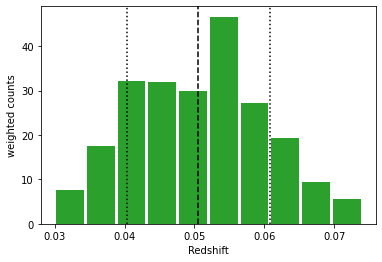

In [60]:
z_stats = get_z_stats(get_type = 'Ic-7')
print(f'z = {z_stats[0][1]:.3f} +-{z_stats[0][2]:.3f}'  )

The same again but for an individual SN. Again the bin components are weighted according to score. This should be a little better than filtering on SN types

z = 0.041 +-0.007


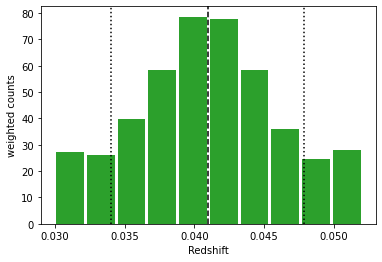

In [61]:
z_stats = get_z_stats(get_sn = 'SN2011bm')
print(f'z = {z_stats[0][1]:.3f} +-{z_stats[0][2]:.3f}'  )

### Plot individual SN matches.
Simply define a part of the SN name to include in the search

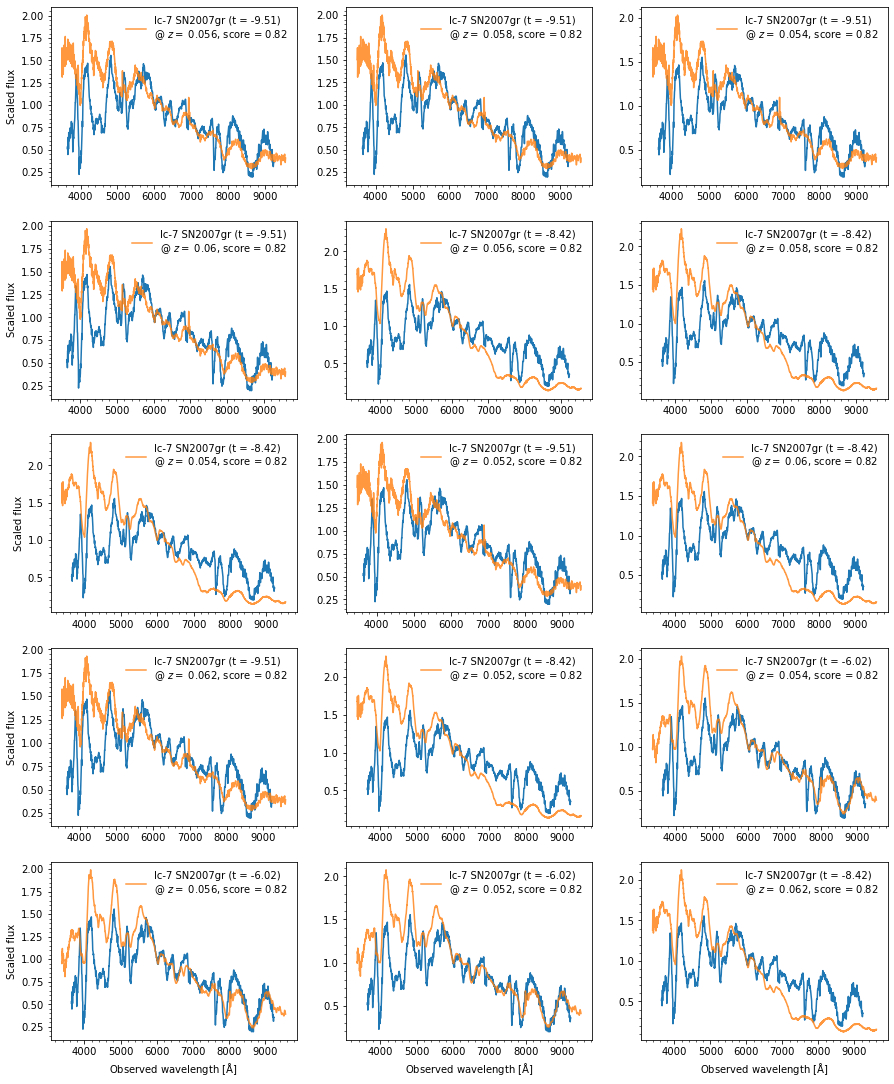

In [75]:
x , y = np.loadtxt(spectrum, usecols = (0,1) ,unpack= True )

scale = y[np.argmin(abs(x-6000))]
y = y / scale

# need a rising index
n= 0

plt.figure(figsize = (15,19))
for i, spec in enumerate(all_specs):
    if '07gr' in spec and n < 15: 
        
        plt.subplot(5,3, n + 1)
        plt.plot(x, y)
    
        x_, y_ = np.loadtxt(ref_location + spec, unpack = True)
    
        x_ = x_ * (1 + zs[i])
    
        scale = y_[np.argmin(abs(x_ - 6000))]
        y_ = y_ / scale
    
        plt.plot(x_, y_, label = f'{types[i]} {sne[i]} (t = {epochs[i]})\n@ $z=$ {zs[i]}, score = {fit_score:.2f}', alpha = 0.8)

        plt.legend(frameon = False)
        plt.minorticks_on()
        
        # this messes up if the limit of n changes
        if n in  [0, 3, 6, 9, 12]:
            plt.ylabel('Scaled flux')
        if n in [14, 13 ,12]:
            plt.xlabel('Observed wavelength [$\mathrm{\AA}$]')
        #plt.show()
        n+=1
